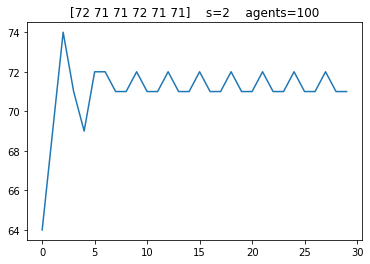

In [1]:
import numpy as np
from matplotlib import pyplot as plt


def make_unbiased_strategies(rng, strategies, memory):
    # weights should sum to 1
    # essentially, we are partitioning the [0,1] interval
    # and taking the size of each sub-interval
    # TODO: add negative weights?
    w = rng.uniform(-1, 1, size=(strategies, memory-1))
    w.sort(axis=1)
    offsets = np.hstack([w[:, :], np.ones(shape=(strategies,1))])
    return offsets - np.hstack([np.zeros(shape=(strategies,1)), w[:, :]])


def make_uniform_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory))


def minimize_squared_error(rng,predictions,observations,threshold,strategies):
        # calculate the absolute error of predictions
        # here, we discard the rightmost prediction as
        # this is the prediction for the future.
        # if we knew the correct answer for that,
        # we wouldn't need to predict it!
        errs = ((predictions[:, :-1] - observations)**2).sum(axis=1)

        return np.argmin(errs)

    
def make_centered_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory)) + 1/memory


def pick_optimal_choices(rng,predictions,observations,threshold,strategies):
    # how often does each predictor match the desired ooutcome?
    performances = np.tile(observations < threshold, (strategies, 1)) == (predictions[:, :-1] < threshold)
    
    # add noise to randomize tie breaker
    scores = rng.uniform(0,0.1, size=strategies) + performances.sum(axis=1)
    return np.argmax(scores)


    
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        strats = [
            strategy_func(rng, strategies, memory) for _ in range(agents)
        ]

        if start is None:
            start = rng.uniform(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = np.zeros((agents, len(hist)))

        # record each agent's prediction on each iteration
        pred_history = np.zeros((agents, len(hist)))

        while t < memory * 2 + n_iter:

            # construct time windows for evaluating strategies

            # The columns begin at
            # t - m - 1 
            # t - m
            # ...
            # t - 1
            # as you go down the column you are looking back
            # to that week's history.
            # so the column beginning at *t - m - 1*
            # generates the prediction for week *t - m*
            # and the rightmost column generates a
            # prediction for next week.
            windows = np.vstack([
                hist[t-memory-i-1: t-i]
                for i in range(memory)
            ])

            for agent in range(agents):
                strat = strats[agent]
                # each row is a strategy
                # each column is predicted attendance
                # in increasing order.
                # the last column has the prediction for
                # next week
                predictions = strat.dot(windows)

                # these are the observations that we use to
                # to test our predictions.
                # note that the observation from column 0
                # is not used since its prediction would come
                # from a previous week's history.
                observations = windows[0, 1:]
                
                best_strat = best_strat_func(rng, predictions, observations, threshold, strategies)
                best_strats[agent, t] = best_strat

                pred = strat[best_strat].dot(windows[:,-1])
                pred_history[agent, t] = pred

            hist[t] = (pred_history[:, t] < threshold).sum()
            t += 1
            
        self.hist = hist[2*memory:]
        self.best_strats = best_strats[:, 2*memory:]
        self.pred_history = pred_history[:, 2*memory:]
        self.strats = strats
        
    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]
        
        
        

rng = np.random.default_rng(36)
h =  np.array([33, 95, 74, 85])
s = 2
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [3]:
threshold = 60

strategies, memory = np.meshgrid(np.arange(2, 103, 5), np.arange(2, 103, 5))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()

<ipython-input-4-8ec5372cca92>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


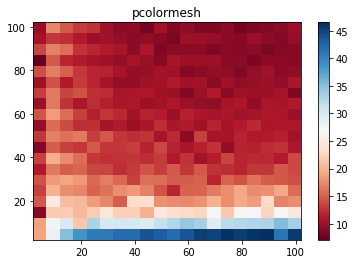

In [4]:
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

In [5]:
threshold = 30

strategies, memory = np.meshgrid(np.arange(2, 103, 5), np.arange(2, 103, 5))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()

<ipython-input-6-8ec5372cca92>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


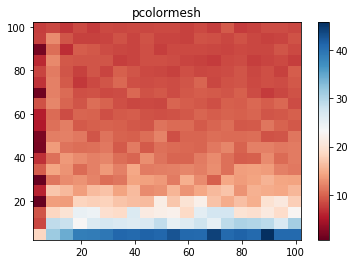

In [6]:
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

In [7]:
threshold = 90

strategies, memory = np.meshgrid(np.arange(2, 103, 5), np.arange(2, 103, 5))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()

Does not cross threshold at (0, 0)
Does not cross threshold at (1, 0)
Does not cross threshold at (2, 0)
Does not cross threshold at (3, 0)
Does not cross threshold at (4, 0)
Does not cross threshold at (5, 0)
Does not cross threshold at (6, 0)
Does not cross threshold at (7, 0)
Does not cross threshold at (8, 0)
Does not cross threshold at (9, 0)
Does not cross threshold at (10, 0)
Does not cross threshold at (11, 0)
Does not cross threshold at (12, 0)
Does not cross threshold at (13, 0)
Does not cross threshold at (14, 0)
Does not cross threshold at (15, 0)
Does not cross threshold at (16, 0)
Does not cross threshold at (17, 0)
Does not cross threshold at (18, 0)
Does not cross threshold at (19, 0)
Does not cross threshold at (20, 0)


<ipython-input-8-8ec5372cca92>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


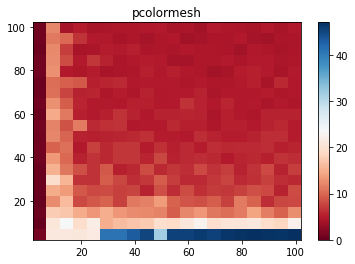

In [8]:
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

In [9]:
strategies[0,1]

7

In [10]:
memory[0,1]

2

<ipython-input-16-f6078ba16b8a>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


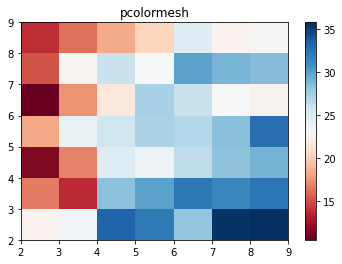

In [16]:
threshold = 60

strategies, memory = np.meshgrid(np.arange(2, 10), np.arange(2, 10))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()
        
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
#ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

<ipython-input-17-e45a52ccab5a>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


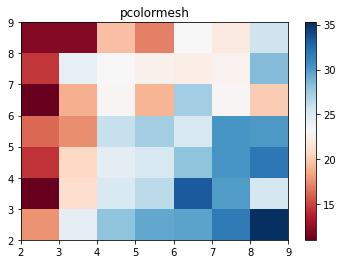

In [17]:
threshold = 30

strategies, memory = np.meshgrid(np.arange(2, 10), np.arange(2, 10))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()
        
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
fig.colorbar(c, ax=ax)

plt.show()

Does not cross threshold at (0, 0)
Does not cross threshold at (0, 1)
Does not cross threshold at (1, 0)
Does not cross threshold at (1, 1)
Does not cross threshold at (2, 0)
Does not cross threshold at (2, 1)
Does not cross threshold at (3, 0)
Does not cross threshold at (3, 1)
Does not cross threshold at (4, 0)
Does not cross threshold at (5, 0)
Does not cross threshold at (5, 1)
Does not cross threshold at (6, 0)
Does not cross threshold at (6, 1)
Does not cross threshold at (7, 0)


<ipython-input-18-21e95263f3c0>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


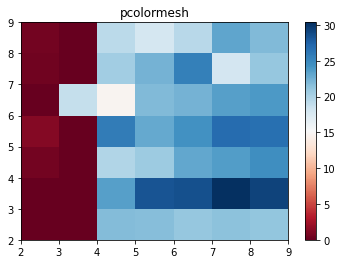

In [18]:
threshold = 90

strategies, memory = np.meshgrid(np.arange(2, 10), np.arange(2, 10))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()
        
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
fig.colorbar(c, ax=ax)

plt.show()

Does not cross threshold at (1, 0)
Does not cross threshold at (3, 0)
Does not cross threshold at (4, 0)
Does not cross threshold at (4, 1)
Does not cross threshold at (6, 0)
Does not cross threshold at (6, 1)
Does not cross threshold at (7, 0)


<ipython-input-19-0b70bd6b658a>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


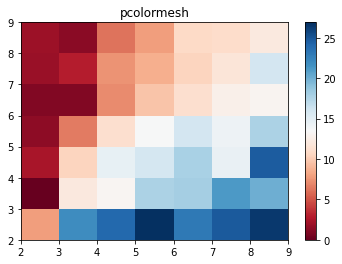

In [19]:
threshold = 10

strategies, memory = np.meshgrid(np.arange(2, 10), np.arange(2, 10))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()
        
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
fig.colorbar(c, ax=ax)

plt.show()

<ipython-input-15-104b2c38adc1>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


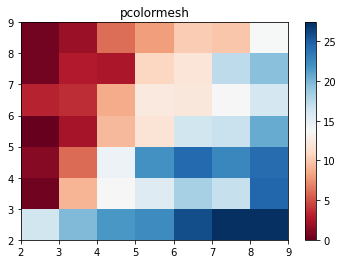

In [15]:
        
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
#ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

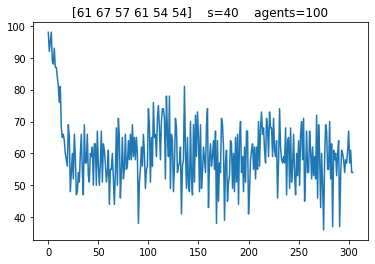

In [43]:
s = 40
m = 102
threshold = 60

h = rng.choice(agents+1, size=m*2)
n_iter = max(100, m * 3) - 1

sim = EFBPSim(
    memory=m, 
    strategies=s,
    threshold=threshold,
    start=h, 
    n_iter=n_iter,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(100000)
)

end_window = max(m * 2, 50)

# does it cross the threshold within the memory window?
under_t = (sim.hist[-end_window:] < threshold).sum()
if under_t == 0 or under_t == end_window:
    print(f"Does not cross threshold at ({i}, {j})")
    

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [44]:
sim.hist

array([98, 92, 95, 98, 89, 88, 93, 87, 87, 84, 81, 76, 81, 68, 65, 66, 64,
       60, 58, 56, 69, 65, 48, 54, 60, 52, 66, 59, 47, 48, 54, 51, 60, 66,
       54, 47, 69, 57, 57, 66, 53, 51, 60, 59, 62, 50, 63, 63, 50, 67, 56,
       50, 57, 67, 51, 63, 61, 57, 51, 54, 61, 44, 55, 55, 60, 52, 44, 54,
       68, 50, 71, 65, 46, 54, 65, 52, 55, 66, 55, 56, 64, 58, 66, 58, 69,
       59, 65, 58, 65, 60, 38, 51, 55, 62, 56, 66, 60, 49, 55, 56, 74, 69,
       51, 65, 56, 76, 65, 66, 59, 71, 75, 68, 58, 70, 74, 74, 71, 52, 78,
       66, 59, 78, 49, 66, 64, 48, 56, 71, 68, 54, 56, 57, 62, 41, 56, 58,
       81, 61, 49, 65, 50, 48, 70, 52, 47, 69, 51, 72, 59, 73, 65, 48, 69,
       49, 54, 62, 58, 54, 69, 74, 43, 58, 63, 56, 59, 64, 55, 67, 38, 64,
       45, 57, 54, 71, 69, 62, 39, 57, 61, 45, 51, 53, 64, 63, 49, 60, 48,
       65, 51, 66, 44, 65, 70, 54, 59, 48, 62, 51, 67, 67, 41, 48, 58, 61,
       63, 55, 62, 52, 62, 55, 70, 56, 68, 73, 66, 68, 61, 57, 71, 68, 59,
       73, 68, 68, 59, 71

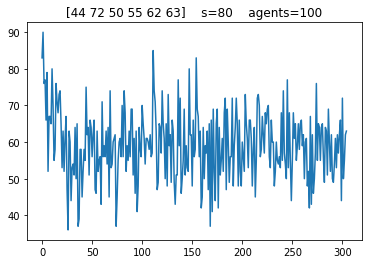

In [45]:
s = 80
m = 102
threshold = 60

h = rng.choice(agents+1, size=m*2)
n_iter = max(100, m * 3) - 1

sim = EFBPSim(
    memory=m, 
    strategies=s,
    threshold=threshold,
    start=h, 
    n_iter=n_iter,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(100000)
)

end_window = max(m * 2, 50)

# does it cross the threshold within the memory window?
under_t = (sim.hist[-end_window:] < threshold).sum()
if under_t == 0 or under_t == end_window:
    print(f"Does not cross threshold at ({i}, {j})")
    

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")